## Dataset Information
The purpose is to classify a given silhouette as one of four types of vehicle, using  a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.  

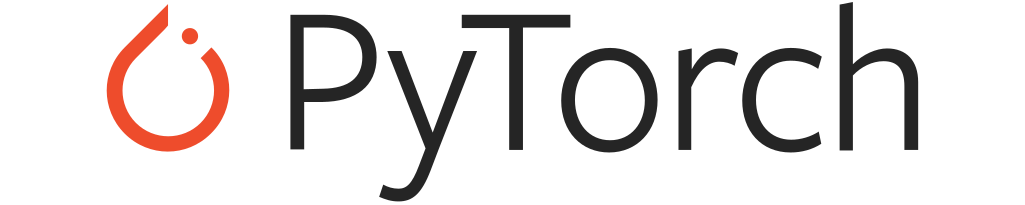

# 1.Preparing the data and getting the necessary libraries

**1.1 Installing torchmetrics library**

In [5]:
!pip install torchmetrics

**1.2 importing the necessary libraries**

In [6]:
import warnings
warnings.filterwarnings('ignore')
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import torchmetrics

**1.3 Transforming the data into CSV**

In [7]:

df = pd.read_csv('vehicle_data.csv')
df

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR_AXIS,SCALED_VARIANCE_MINOR_AXIS,SCALED_RADIUS_OF_GYRATION,SKEWNESS_MAJOR_AXIS,SKEWNESS_MINOR_AXIS,KURTOSIS_MINOR_AXIS,KURTOSIS_MAJOR_AXIS,HOLLOWS_RATIO,CLASS_LABEL
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,van
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,saab


# 2.Exploratory data analysis

**2.1 Checking for any issue in the data types or any missing values**

In [ ]:
df.info()

**2.2 Checking the variation in the target column**

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['CLASS_LABEL'])
plt.title('Distribution of Class Labels')
plt.ylabel('Count')
plt.show()

**2.3 Statistical summary**

In [ ]:
desc = df.describe().T
desc['skew'] = df.iloc[:,:-1].skew()
desc['kurtosis'] = df.iloc[:,:-1].kurtosis()
desc

**2.4 Display the distribution of the skewed features**

In [ ]:
df.hist(bins=25, figsize=(12,8))
plt.tight_layout()
plt.show()

**2.5 Is there's outliers ?**

In [ ]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


**2.6 Identify highly collinear features**

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=np.triu(correlation_matrix), annot=True)
plt.show()

# 3. Actions


We will:
1.   Remove **highly collinear** features (2.6)
2.   Transform the **Skewed** features (2.3)



3.1 Start with 2.6

In [8]:
df.drop(['ELONGATEDNESS','PR.AXIS_RECTANGULARITY','MAX.LENGTH_RECTANGULARITY'],axis=1,inplace=True)

3.2 now with 2.3

In [9]:
df[['PR.AXIS_ASPECT_RATIO','MAX.LENGTH_ASPECT_RATIO','PR.AXIS_ASPECT_RATIO']].skew()

,0
PR.AXIS_ASPECT_RATIO,3.821560
MAX.LENGTH_ASPECT_RATIO,6.778394
PR.AXIS_ASPECT_RATIO,3.821560


In [10]:
for col in ['PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'PR.AXIS_ASPECT_RATIO']:
  df[col] = np.log1p(df[col])

df[['PR.AXIS_ASPECT_RATIO','MAX.LENGTH_ASPECT_RATIO','PR.AXIS_ASPECT_RATIO']].skew()

,0
PR.AXIS_ASPECT_RATIO,1.548952
MAX.LENGTH_ASPECT_RATIO,1.570454
PR.AXIS_ASPECT_RATIO,1.548952


# 4. Prepare the data to build a model

4.1 Splitting the data into:
*   Training set 70%
*   Validation set 20%
*   Testing set 10%

with Scaling and encoding the features



In [170]:
x = df.drop('CLASS_LABEL',axis=1)
y = df['CLASS_LABEL']

y = LabelEncoder().fit_transform(y)

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

**4.2 To tensor type**

In [171]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

**4.3 Here's the trick as we don't have enough data we will force it to be enough by ⚡*OverSampling*⚡**

In [172]:
sampling_strategy = {class_label: count * 50 for class_label, count in zip(*np.unique(y_train.numpy(), return_counts=True))}
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

x_train_resampled, y_train_resampled = oversampler.fit_resample(x_train.numpy(), y_train.numpy())

x_train = torch.tensor(x_train_resampled, dtype=torch.float32)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)

In [173]:
x_train.shape

torch.Size([29600, 15])

# 5. Deep Network with PyTorch

**5.1 Define the Neural Network**

In [221]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.shortcut2 = nn.Linear(512, 256)  # Projection shortcut

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.shortcut3 = nn.Linear(256, 128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.shortcut4 = nn.Linear(128, 64)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.shortcut5 = nn.Linear(64, 32)

        self.fc6 = nn.Linear(32, 16)
        self.bn6 = nn.BatchNorm1d(16)
        self.shortcut6 = nn.Linear(32, 16)

        self.fc7 = nn.Linear(16, 8)
        self.bn7 = nn.BatchNorm1d(8)
        self.shortcut7 = nn.Linear(16, 8)

        self.fc8 = nn.Linear(8, num_classes)

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 2 with residual connection
        identity = self.shortcut2(x)  # Project previous x to 256 dim
        x = self.fc2(x)
        x = self.bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 3 with residual connection
        identity = self.shortcut3(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 4 with residual connection
        identity = self.shortcut4(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x += identity
        x = self.relu(x)

        # Layer 5 with residual connection
        identity = self.shortcut5(x)
        x = self.fc5(x)
        x = self.bn5(x)
        x += identity
        x = self.relu(x)

        # Layer 6 with residual connection
        identity = self.shortcut6(x)
        x = self.fc6(x)
        x = self.bn6(x)
        x += identity
        x = self.relu(x)

        # Layer 7 with residual connection
        identity = self.shortcut7(x)
        x = self.fc7(x)
        x = self.bn7(x)
        x += identity
        x = self.relu(x)

        # Output layer
        x = self.fc8(x)
        return x

    def init_weights(self):
        """
        Initialize the weights of all linear layers using Xavier uniform.
        Biases are initialized to zero.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)


model = SimpleNN(x_train.shape[1], len(np.unique(y_train)))
model.init_weights()

**5.2 Define Loss Function and Optimizer**

In [222]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**5.3 New metric Accuracy !!**

In [223]:
metric = torchmetrics.Accuracy(task="multiclass", num_classes=4)

**5.4 Train and evaluate the Model**

In [224]:
for epoch in range(200):
    # Training Phase
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_acc = metric(outputs, y_train)

    # Validation Phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_acc = metric(val_outputs, y_val)

    if epoch % 5 == 0:
        print(f"Epoch [{epoch}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f},{'-'*5} Accuracy: {train_acc.item():.4f}, Validation Accuracy: {val_acc.item():.4f}")

Epoch [0], Loss: 1.7613, Validation Loss: 1.3280,----- Accuracy: 0.2712, Validation Accuracy: 0.4882
Epoch [5], Loss: 1.3028, Validation Loss: 1.2296,----- Accuracy: 0.3548, Validation Accuracy: 0.4173
Epoch [10], Loss: 1.1721, Validation Loss: 1.1255,----- Accuracy: 0.4771, Validation Accuracy: 0.5984
Epoch [15], Loss: 1.0172, Validation Loss: 0.9410,----- Accuracy: 0.5643, Validation Accuracy: 0.6693
Epoch [20], Loss: 0.8727, Validation Loss: 0.7731,----- Accuracy: 0.6307, Validation Accuracy: 0.6850
Epoch [25], Loss: 0.7463, Validation Loss: 0.6431,----- Accuracy: 0.6591, Validation Accuracy: 0.6929
Epoch [30], Loss: 0.6405, Validation Loss: 0.5476,----- Accuracy: 0.6853, Validation Accuracy: 0.7480
Epoch [35], Loss: 0.5599, Validation Loss: 0.4660,----- Accuracy: 0.7060, Validation Accuracy: 0.7323
Epoch [40], Loss: 0.5076, Validation Loss: 0.4222,----- Accuracy: 0.7220, Validation Accuracy: 0.7402
Epoch [45], Loss: 0.4754, Validation Loss: 0.4075,----- Accuracy: 0.7313, Validation

**5.4 Test the model**

In [225]:
with torch.no_grad():
    outputs = model(x_test)
    predictions = torch.argmax(outputs, axis=1)
    accuracy = metric(predictions, y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 88.98%
